## 기본 베이지 DNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
%matplotlib inline

In [3]:
df=pd.read_excel('./optimal_data3_1/'+'Continous_2weeks_2day_1term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (58825, 6) (58825,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (166896, 6) (166896,)
SMOTE 적용 전 레이블 값 분포: 
 0    55632
1     2010
2     1183
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    55632
1    55632
2    55632
Name: 8, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.20, stratify=y_train_over)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

train_dataset = TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16,shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16,shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [6]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [7]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [8]:
def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

In [9]:
# 최대 Epoch을 지정합니다.
num_epochs = 100
min_loss = 9999999999999
loss_list=[]
acc_list=[]
# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)
    
    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
            print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
            min_loss = val_loss
            torch.save(model.state_dict(), 'DNNModel.pth')

    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
    loss_list.append(train_loss)
    acc_list.append(train_acc)
## 저장한 가중치 로드 후 검증 성능 측정

# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc, pred_list = model_test(model, test_dataloader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 550.00it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.80591. Saving Model!
epoch 01, loss: 0.89893, acc: 0.55123, val_loss: 0.80591, val_accuracy: 0.62220


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 532.38it/s]


[INFO] val_acc has been improved from 0.80591 to 0.66914. Saving Model!
epoch 02, loss: 0.71805, acc: 0.67889, val_loss: 0.66914, val_accuracy: 0.71297


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.74it/s]


[INFO] val_acc has been improved from 0.66914 to 0.58168. Saving Model!
epoch 03, loss: 0.61198, acc: 0.73847, val_loss: 0.58168, val_accuracy: 0.75743


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 534.59it/s]


[INFO] val_acc has been improved from 0.58168 to 0.53353. Saving Model!
epoch 04, loss: 0.54966, acc: 0.77231, val_loss: 0.53353, val_accuracy: 0.78415


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.79it/s]


[INFO] val_acc has been improved from 0.53353 to 0.49589. Saving Model!
epoch 05, loss: 0.50681, acc: 0.79396, val_loss: 0.49589, val_accuracy: 0.80150


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.15it/s]


[INFO] val_acc has been improved from 0.49589 to 0.47290. Saving Model!
epoch 06, loss: 0.47743, acc: 0.80829, val_loss: 0.47290, val_accuracy: 0.80992


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 544.97it/s]


epoch 07, loss: 0.45433, acc: 0.81888, val_loss: 0.47746, val_accuracy: 0.81067


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.27it/s]


[INFO] val_acc has been improved from 0.47290 to 0.44461. Saving Model!
epoch 08, loss: 0.43579, acc: 0.82699, val_loss: 0.44461, val_accuracy: 0.82466


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 541.40it/s]


[INFO] val_acc has been improved from 0.44461 to 0.43938. Saving Model!
epoch 09, loss: 0.42129, acc: 0.83280, val_loss: 0.43938, val_accuracy: 0.82864


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 556.13it/s]


[INFO] val_acc has been improved from 0.43938 to 0.42723. Saving Model!
epoch 10, loss: 0.40915, acc: 0.83794, val_loss: 0.42723, val_accuracy: 0.83385


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.33it/s]


[INFO] val_acc has been improved from 0.42723 to 0.41857. Saving Model!
epoch 11, loss: 0.39813, acc: 0.84299, val_loss: 0.41857, val_accuracy: 0.83478


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 540.18it/s]


[INFO] val_acc has been improved from 0.41857 to 0.40628. Saving Model!
epoch 12, loss: 0.38725, acc: 0.84793, val_loss: 0.40628, val_accuracy: 0.83883


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.15it/s]


[INFO] val_acc has been improved from 0.40628 to 0.40068. Saving Model!
epoch 13, loss: 0.37904, acc: 0.85161, val_loss: 0.40068, val_accuracy: 0.84305


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 543.23it/s]


[INFO] val_acc has been improved from 0.40068 to 0.39125. Saving Model!
epoch 14, loss: 0.37120, acc: 0.85427, val_loss: 0.39125, val_accuracy: 0.84787


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.48it/s]


epoch 15, loss: 0.36385, acc: 0.85763, val_loss: 0.39164, val_accuracy: 0.84629


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 555.15it/s]


[INFO] val_acc has been improved from 0.39125 to 0.37678. Saving Model!
epoch 16, loss: 0.35782, acc: 0.86045, val_loss: 0.37678, val_accuracy: 0.85560


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.28it/s]


[INFO] val_acc has been improved from 0.37678 to 0.37141. Saving Model!
epoch 17, loss: 0.35164, acc: 0.86285, val_loss: 0.37141, val_accuracy: 0.85665


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 557.95it/s]


[INFO] val_acc has been improved from 0.37141 to 0.35814. Saving Model!
epoch 18, loss: 0.34626, acc: 0.86482, val_loss: 0.35814, val_accuracy: 0.86192


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 557.34it/s]


epoch 19, loss: 0.34160, acc: 0.86663, val_loss: 0.36138, val_accuracy: 0.85980


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.82it/s]


epoch 20, loss: 0.33651, acc: 0.86941, val_loss: 0.36348, val_accuracy: 0.85953


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 559.41it/s]


[INFO] val_acc has been improved from 0.35814 to 0.35388. Saving Model!
epoch 21, loss: 0.33179, acc: 0.87083, val_loss: 0.35388, val_accuracy: 0.86456


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.05it/s]


epoch 22, loss: 0.32768, acc: 0.87133, val_loss: 0.35499, val_accuracy: 0.86759


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 549.96it/s]


[INFO] val_acc has been improved from 0.35388 to 0.34630. Saving Model!
epoch 23, loss: 0.32407, acc: 0.87338, val_loss: 0.34630, val_accuracy: 0.87142


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 549.37it/s]


epoch 24, loss: 0.32074, acc: 0.87508, val_loss: 0.34631, val_accuracy: 0.87079


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 543.31it/s]


epoch 25, loss: 0.31686, acc: 0.87615, val_loss: 0.34853, val_accuracy: 0.86980


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 559.16it/s]


epoch 26, loss: 0.31319, acc: 0.87755, val_loss: 0.34981, val_accuracy: 0.86794


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 557.74it/s]


[INFO] val_acc has been improved from 0.34630 to 0.32814. Saving Model!
epoch 27, loss: 0.31129, acc: 0.87906, val_loss: 0.32814, val_accuracy: 0.87804


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.92it/s]


epoch 28, loss: 0.30763, acc: 0.88077, val_loss: 0.33379, val_accuracy: 0.87481


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 559.16it/s]


epoch 29, loss: 0.30418, acc: 0.88211, val_loss: 0.33083, val_accuracy: 0.87484


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.02it/s]


[INFO] val_acc has been improved from 0.32814 to 0.32797. Saving Model!
epoch 30, loss: 0.30207, acc: 0.88219, val_loss: 0.32797, val_accuracy: 0.87522


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 557.88it/s]


epoch 31, loss: 0.29987, acc: 0.88369, val_loss: 0.33307, val_accuracy: 0.87151


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 556.79it/s]


[INFO] val_acc has been improved from 0.32797 to 0.32590. Saving Model!
epoch 32, loss: 0.29776, acc: 0.88386, val_loss: 0.32590, val_accuracy: 0.87945


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.78it/s]


epoch 33, loss: 0.29491, acc: 0.88522, val_loss: 0.32909, val_accuracy: 0.87379


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 558.07it/s]


[INFO] val_acc has been improved from 0.32590 to 0.32393. Saving Model!
epoch 34, loss: 0.29352, acc: 0.88608, val_loss: 0.32393, val_accuracy: 0.87900


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:14<00:00, 557.50it/s]


[INFO] val_acc has been improved from 0.32393 to 0.32247. Saving Model!
epoch 35, loss: 0.28994, acc: 0.88715, val_loss: 0.32247, val_accuracy: 0.87855


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.71it/s]


[INFO] val_acc has been improved from 0.32247 to 0.31882. Saving Model!
epoch 36, loss: 0.28855, acc: 0.88807, val_loss: 0.31882, val_accuracy: 0.87966


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.28it/s]


[INFO] val_acc has been improved from 0.31882 to 0.31795. Saving Model!
epoch 37, loss: 0.28671, acc: 0.88859, val_loss: 0.31795, val_accuracy: 0.88032


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.69it/s]


epoch 38, loss: 0.28482, acc: 0.88990, val_loss: 0.32236, val_accuracy: 0.87774


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.63it/s]


epoch 39, loss: 0.28250, acc: 0.89046, val_loss: 0.31905, val_accuracy: 0.87918


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.95it/s]


[INFO] val_acc has been improved from 0.31795 to 0.31371. Saving Model!
epoch 40, loss: 0.28044, acc: 0.89117, val_loss: 0.31371, val_accuracy: 0.88214


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.33it/s]


epoch 41, loss: 0.27930, acc: 0.89147, val_loss: 0.31742, val_accuracy: 0.87954


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.91it/s]


[INFO] val_acc has been improved from 0.31371 to 0.31168. Saving Model!
epoch 42, loss: 0.27729, acc: 0.89252, val_loss: 0.31168, val_accuracy: 0.88379


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.10it/s]


epoch 43, loss: 0.27396, acc: 0.89326, val_loss: 0.31472, val_accuracy: 0.88406


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.51it/s]


[INFO] val_acc has been improved from 0.31168 to 0.30569. Saving Model!
epoch 44, loss: 0.27357, acc: 0.89350, val_loss: 0.30569, val_accuracy: 0.88694


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.87it/s]


epoch 45, loss: 0.27228, acc: 0.89362, val_loss: 0.30787, val_accuracy: 0.88466


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.75it/s]


epoch 46, loss: 0.27100, acc: 0.89439, val_loss: 0.31369, val_accuracy: 0.88250


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.29it/s]


epoch 47, loss: 0.27074, acc: 0.89448, val_loss: 0.31077, val_accuracy: 0.88259


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.67it/s]


epoch 48, loss: 0.26895, acc: 0.89586, val_loss: 0.30677, val_accuracy: 0.88505


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.79it/s]


epoch 49, loss: 0.26706, acc: 0.89626, val_loss: 0.30889, val_accuracy: 0.88616


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.25it/s]


[INFO] val_acc has been improved from 0.30569 to 0.30494. Saving Model!
epoch 50, loss: 0.26569, acc: 0.89722, val_loss: 0.30494, val_accuracy: 0.88628


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.83it/s]


epoch 51, loss: 0.26563, acc: 0.89707, val_loss: 0.30502, val_accuracy: 0.88514


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 545.53it/s]


[INFO] val_acc has been improved from 0.30494 to 0.29539. Saving Model!
epoch 52, loss: 0.26411, acc: 0.89779, val_loss: 0.29539, val_accuracy: 0.89182


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.06it/s]


epoch 53, loss: 0.26263, acc: 0.89798, val_loss: 0.30233, val_accuracy: 0.88880


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.82it/s]


epoch 54, loss: 0.26111, acc: 0.89807, val_loss: 0.29547, val_accuracy: 0.88763


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.60it/s]


epoch 55, loss: 0.25940, acc: 0.89906, val_loss: 0.30670, val_accuracy: 0.88658


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.06it/s]


epoch 56, loss: 0.25894, acc: 0.89906, val_loss: 0.30585, val_accuracy: 0.88691


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.43it/s]


epoch 57, loss: 0.25687, acc: 0.89963, val_loss: 0.30316, val_accuracy: 0.88996


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.16it/s]


epoch 58, loss: 0.25642, acc: 0.90067, val_loss: 0.30225, val_accuracy: 0.88481


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.21it/s]


epoch 59, loss: 0.25455, acc: 0.90156, val_loss: 0.29741, val_accuracy: 0.89386


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 549.06it/s]


epoch 60, loss: 0.25508, acc: 0.90154, val_loss: 0.29833, val_accuracy: 0.88939


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 555.10it/s]


epoch 61, loss: 0.25272, acc: 0.90238, val_loss: 0.30046, val_accuracy: 0.88936


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.24it/s]


epoch 62, loss: 0.25215, acc: 0.90257, val_loss: 0.29808, val_accuracy: 0.89131


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.50it/s]


epoch 63, loss: 0.25153, acc: 0.90204, val_loss: 0.30354, val_accuracy: 0.88963


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.87it/s]


[INFO] val_acc has been improved from 0.29539 to 0.29146. Saving Model!
epoch 64, loss: 0.25114, acc: 0.90288, val_loss: 0.29146, val_accuracy: 0.89164


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.22it/s]


epoch 65, loss: 0.25048, acc: 0.90323, val_loss: 0.29968, val_accuracy: 0.89047


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 555.24it/s]


[INFO] val_acc has been improved from 0.29146 to 0.29046. Saving Model!
epoch 66, loss: 0.24956, acc: 0.90379, val_loss: 0.29046, val_accuracy: 0.89392


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 549.85it/s]


epoch 67, loss: 0.24782, acc: 0.90405, val_loss: 0.29315, val_accuracy: 0.89257


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 545.94it/s]


epoch 68, loss: 0.24768, acc: 0.90433, val_loss: 0.30108, val_accuracy: 0.89005


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.42it/s]


epoch 69, loss: 0.24557, acc: 0.90554, val_loss: 0.29411, val_accuracy: 0.89212


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.94it/s]


epoch 70, loss: 0.24572, acc: 0.90528, val_loss: 0.29447, val_accuracy: 0.89173


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 555.11it/s]


epoch 71, loss: 0.24447, acc: 0.90522, val_loss: 0.29492, val_accuracy: 0.89317


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.56it/s]


epoch 72, loss: 0.24429, acc: 0.90612, val_loss: 0.29266, val_accuracy: 0.89401


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.33it/s]


epoch 73, loss: 0.24348, acc: 0.90595, val_loss: 0.29631, val_accuracy: 0.89317


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.81it/s]


[INFO] val_acc has been improved from 0.29046 to 0.28706. Saving Model!
epoch 74, loss: 0.24389, acc: 0.90560, val_loss: 0.28706, val_accuracy: 0.89670


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.69it/s]


epoch 75, loss: 0.24215, acc: 0.90640, val_loss: 0.29987, val_accuracy: 0.89029


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 549.88it/s]


epoch 76, loss: 0.24172, acc: 0.90654, val_loss: 0.29809, val_accuracy: 0.89449


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.23it/s]


epoch 77, loss: 0.24007, acc: 0.90748, val_loss: 0.28847, val_accuracy: 0.89551


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 546.42it/s]


epoch 78, loss: 0.23981, acc: 0.90761, val_loss: 0.28811, val_accuracy: 0.89623


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.98it/s]


epoch 79, loss: 0.23938, acc: 0.90786, val_loss: 0.29169, val_accuracy: 0.89365


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.66it/s]


epoch 80, loss: 0.23858, acc: 0.90783, val_loss: 0.29214, val_accuracy: 0.89476


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 545.57it/s]


epoch 81, loss: 0.23819, acc: 0.90819, val_loss: 0.28830, val_accuracy: 0.89416


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.02it/s]


epoch 82, loss: 0.23648, acc: 0.90947, val_loss: 0.29459, val_accuracy: 0.89212


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.18it/s]


epoch 83, loss: 0.23659, acc: 0.90922, val_loss: 0.29341, val_accuracy: 0.89314


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.69it/s]


epoch 84, loss: 0.23588, acc: 0.90907, val_loss: 0.29183, val_accuracy: 0.89296


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.67it/s]


[INFO] val_acc has been improved from 0.28706 to 0.28554. Saving Model!
epoch 85, loss: 0.23444, acc: 0.90923, val_loss: 0.28554, val_accuracy: 0.89380


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.73it/s]


epoch 86, loss: 0.23493, acc: 0.90898, val_loss: 0.28712, val_accuracy: 0.89667


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 555.20it/s]


epoch 87, loss: 0.23476, acc: 0.90991, val_loss: 0.28984, val_accuracy: 0.89371


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.86it/s]


epoch 88, loss: 0.23355, acc: 0.91067, val_loss: 0.29154, val_accuracy: 0.89317


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.74it/s]


epoch 89, loss: 0.23242, acc: 0.91075, val_loss: 0.29443, val_accuracy: 0.89398


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.96it/s]


epoch 90, loss: 0.23286, acc: 0.91037, val_loss: 0.29371, val_accuracy: 0.89599


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 551.38it/s]


epoch 91, loss: 0.23136, acc: 0.91062, val_loss: 0.29016, val_accuracy: 0.89617


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 550.47it/s]


[INFO] val_acc has been improved from 0.28554 to 0.28314. Saving Model!
epoch 92, loss: 0.23130, acc: 0.91062, val_loss: 0.28314, val_accuracy: 0.89473


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 553.18it/s]


epoch 93, loss: 0.23067, acc: 0.91137, val_loss: 0.29219, val_accuracy: 0.89551


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 547.39it/s]


epoch 94, loss: 0.23022, acc: 0.91148, val_loss: 0.29419, val_accuracy: 0.89335


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 555.08it/s]


epoch 95, loss: 0.22994, acc: 0.91115, val_loss: 0.28496, val_accuracy: 0.89596


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.50it/s]


epoch 96, loss: 0.22878, acc: 0.91203, val_loss: 0.28642, val_accuracy: 0.89572


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 548.38it/s]


epoch 97, loss: 0.22829, acc: 0.91228, val_loss: 0.28492, val_accuracy: 0.89691


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 554.73it/s]


epoch 98, loss: 0.22896, acc: 0.91236, val_loss: 0.28412, val_accuracy: 0.89877


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 550.34it/s]


epoch 99, loss: 0.22636, acc: 0.91283, val_loss: 0.29796, val_accuracy: 0.89425


100%|█████████████████████████████████████████████████████████████████████████████| 8345/8345 [00:15<00:00, 552.49it/s]


epoch 100, loss: 0.22676, acc: 0.91236, val_loss: 0.28949, val_accuracy: 0.89551
evaluation loss: 0.28314, evaluation accuracy: 0.89473


In [10]:
pred_list

[[0, 2, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 2, 2, 1, 2],
 [1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1],
 [2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 0, 2],
 [0, 1, 2, 0, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
 [1, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 2],
 [0, 1, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1],
 [2, 0, 2, 0, 1, 2, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2],
 [0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 2],
 [2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2],
 [0, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 2, 2, 0, 1, 1],
 [2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2],
 [2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1],
 [2, 0, 2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1],
 [1, 2, 2, 0, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 2, 0],
 [2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 1, 2],
 [1, 2, 1, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0],
 [1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0],
 [1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1],
 [1, 1, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2, 0, 1, 2],
 [0, 2, 1, 1, 0, 2, 1, 0, 0, 1,

In [11]:
listarray=[]
for i in pred_list:
    for j in i:
        listarray.append(j)

In [12]:
listarray

[0,
 2,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 0,


## 그래프 그리기

In [13]:
train_loss_list = torch.tensor(loss_list)
train_acc_list = torch.tensor(acc_list)

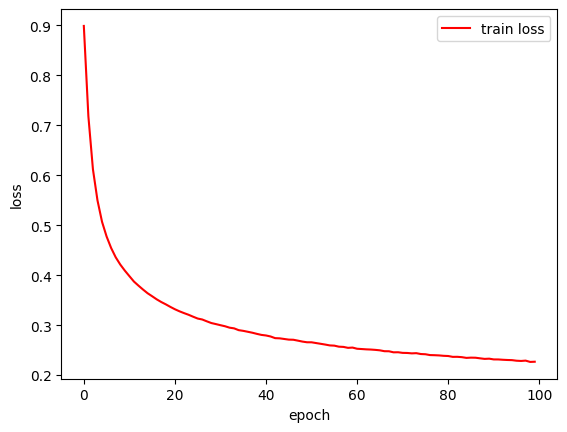

In [14]:

plt.plot(train_loss_list, label='train loss',color='red')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

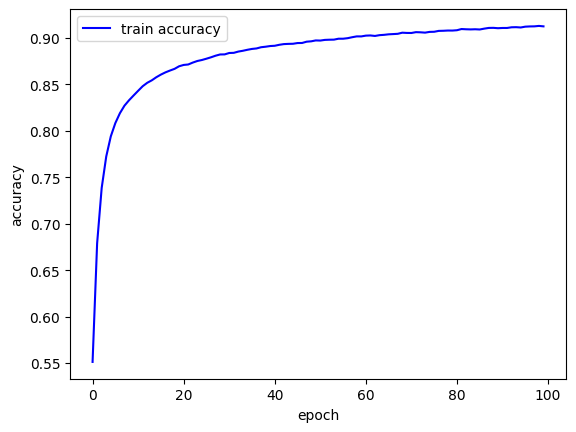

In [15]:
plt.plot(train_acc_list, label='train accuracy',color='blue')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion matrix

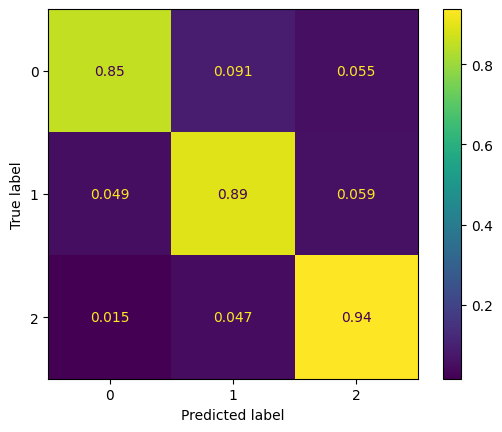

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, listarray)

cm = confusion_matrix(y_test, listarray, labels=[0,1,2],normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
disp.plot()
plt.show()

In [17]:
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
f1 = f1_score(y_test,listarray,pos_label='positive', average='micro')
accuracy_score=accuracy_score(y_test, listarray) * 100
print(f1)
print("정확도: {}".format(accuracy_score))

0.8947273816656681
정확도: 89.47273816656681


C:\Users\jaemin\Anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [18]:

print('SMOTE 적용 후 테스트용 피처/레이블 데이터 세트: ', X_test.shape, y_test.shape)
# print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_test).value_counts())

SMOTE 적용 후 테스트용 피처/레이블 데이터 세트:  torch.Size([33380, 6]) torch.Size([33380])
SMOTE 적용 후 레이블 값 분포: 
 2    11127
1    11127
0    11126
dtype: int64


In [19]:
from collections import Counter
result = Counter(listarray)

In [20]:
result

Counter({0: 10225, 2: 11695, 1: 11460})

### AUC

In [21]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [22]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# make sample data
n_classes = 3


print("roc_auc_score: ", multiclass_roc_auc_score(y_test, listarray))

roc_auc_score:  0.9210447798836056
